# 🌪️ Storm Damage Prediction — **All‑in‑One v5.7** (GPU‑aware, fast)

**Goals**
- Predict **Property** and **Crop** damages from NOAA Storm Events.
- Add **geospatial**, **network**, and **text embedding** features.
- Fit **Tweedie XGBoost** with **Slim Optuna** on GPU (if available).
- Provide **Quantile XGB** intervals (p10/p50/p90) with reliability plots.
- Compute **SHAP** with **decoded feature names** (Option B).
- Save artefacts in `./results`.


In [1]:
# === 0) Setup & Utilities ===
import os, sys, json, math, gc, warnings, platform
from pathlib import Path
import numpy as np
import pandas as pd
from contextlib import contextmanager
warnings.filterwarnings("ignore")

# Repro
SEED = 42
np.random.seed(SEED)

# Runtime mode: '2h' (default), '3h', 'full'
MODE = os.environ.get("STORM_MODE", "2h")

# Paths
OUTDIR = Path("./results"); OUTDIR.mkdir(parents=True, exist_ok=True)

@contextmanager
def timer(label):
    import time
    t0=time.time()
    print(f"⏳ {label} ...", flush=True)
    try:
        yield
    finally:
        dt=time.time()-t0
        print(f"✅ {label} — {dt:,.1f}s", flush=True)

def save_json(obj, path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

def save_joblib(model, path):
    import joblib
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(model, path)

# GPU?
try:
    import torch
    HAS_CUDA = torch.cuda.is_available()
except Exception:
    HAS_CUDA = False
print("CUDA available:", HAS_CUDA)

print("MODE:", MODE)
print("Python:", sys.version.split()[0], "| OS:", platform.system(), platform.release())


CUDA available: True
MODE: 2h
Python: 3.11.7 | OS: Windows 10


In [2]:
# === 1) Load & Clean CSV ===
def parse_damage(v):
    if pd.isna(v): return np.nan
    s = str(v).strip().upper()
    if not s: return np.nan
    mult = 1.0
    if s.endswith("K"): mult, s = 1_000.0, s[:-1]
    elif s.endswith("M"): mult, s = 1_000_000.0, s[:-1]
    elif s.endswith("B"): mult, s = 1_000_000_000.0, s[:-1]
    try:
        return float(s) * mult
    except:
        try:
            return float(s.replace(",",""))
        except:
            return np.nan

CSV_PATH = os.environ.get("STORM_CSV", "./StormEvents_details-ftp_v1.0_d2013_c20250520.csv")
print("CSV_PATH:", CSV_PATH)

df = pd.read_csv(CSV_PATH, low_memory=False, encoding="utf-8")
df.columns = [c.strip().upper() for c in df.columns]

assert "DAMAGE_PROPERTY" in df.columns and "DAMAGE_CROPS" in df.columns, "Targets missing"

df["Y_PROP"] = df["DAMAGE_PROPERTY"].apply(parse_damage)
df["Y_CROP"] = df["DAMAGE_CROPS"].apply(parse_damage)
df = df[(df["Y_PROP"].notna()) | (df["Y_CROP"].notna())].copy()

# Dates & duration
for c in ["BEGIN_DATE_TIME","END_DATE_TIME"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
df["DURATION_HOURS"] = (df["END_DATE_TIME"] - df["BEGIN_DATE_TIME"]).dt.total_seconds()/3600.0
df["DURATION_HOURS"] = df["DURATION_HOURS"].clip(lower=0).fillna(0)

# Geospatial mean + sin/cos + great-circle baseline dist
for c in ["BEGIN_LAT","BEGIN_LON","END_LAT","END_LON"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["LAT_MEAN"] = df[["BEGIN_LAT","END_LAT"]].mean(axis=1)
df["LON_MEAN"] = df[["BEGIN_LON","END_LON"]].mean(axis=1)
df["LAT_SIN"] = np.sin(np.deg2rad(df["LAT_MEAN"]))
df["LAT_COS"] = np.cos(np.deg2rad(df["LAT_MEAN"]))
df["LON_SIN"] = np.sin(np.deg2rad(df["LON_MEAN"]))
df["LON_COS"] = np.cos(np.deg2rad(df["LON_MEAN"]))

# Haversine approx distance of event span
def hav_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.deg2rad(lat1); lat2 = np.deg2rad(lat2)
    dlat = lat2 - lat1; dlon = np.deg2rad(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))
df["SPAN_KM"] = hav_km(df["BEGIN_LAT"], df["BEGIN_LON"], df["END_LAT"], df["END_LON"]).fillna(0)

# Drop unhelpful ids
for c in ["EPISODE_ID","EVENT_ID","DATA_SOURCE","BEGIN_RANGE","END_RANGE","BEGIN_AZIMUTH","END_AZIMUTH"]:
    if c in df.columns: df.drop(columns=c, inplace=True, errors="ignore")

print("Cleaned shape:", df.shape)
df.head(2)


CSV_PATH: ./StormEvents_details-ftp_v1.0_d2013_c20250520.csv
Cleaned shape: (52259, 54)


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE,STATE_FIPS,YEAR,MONTH_NAME,...,Y_PROP,Y_CROP,DURATION_HOURS,LAT_MEAN,LON_MEAN,LAT_SIN,LAT_COS,LON_SIN,LON_COS,SPAN_KM
0,201302,23,1900,201302,25,400,NEW HAMPSHIRE,33,2013,February,...,0.0,0.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,201312,14,2100,201312,15,1300,NEW HAMPSHIRE,33,2013,December,...,0.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [3]:
# === 2) Feature lists & targets ===
text_cols = [c for c in ["EPISODE_NARRATIVE","EVENT_NARRATIVE"] if c in df.columns]
num_cols  = [c for c in ["INJURIES_DIRECT","INJURIES_INDIRECT","DEATHS_DIRECT","DEATHS_INDIRECT",
                         "DURATION_HOURS","LAT_MEAN","LON_MEAN","LAT_SIN","LAT_COS","LON_SIN","LON_COS","SPAN_KM"]
             if c in df.columns]
cat_cols  = [c for c in ["STATE","CZ_NAME","EVENT_TYPE","WFO","STATE_FIPS","CZ_FIPS","CZ_TYPE"] if c in df.columns]

X_cols = [*num_cols, *cat_cols, *text_cols]
y = df[["Y_PROP","Y_CROP"]].to_numpy().astype("float32")
# log1p for regression heads that prefer log-scale
y_log = np.log1p(np.clip(y, a_min=0, a_max=None))

print("Text:", text_cols)
print("Num :", len(num_cols), "Cat:", len(cat_cols))
print("X columns:", len(X_cols))


Text: ['EPISODE_NARRATIVE', 'EVENT_NARRATIVE']
Num : 12 Cat: 7
X columns: 21


In [4]:
# === 3a) Split ===
from sklearn.model_selection import train_test_split
X = df[X_cols].copy()

X_train, X_temp, y_train, y_temp, y_train_log, y_temp_log = train_test_split(
    X, y, y_log, test_size=0.30, random_state=SEED
)
X_valid, X_test, y_valid, y_test, y_valid_log, y_test_log = train_test_split(
    X_temp, y_temp, y_temp_log, test_size=0.50, random_state=SEED
)

print("Splits:")
print(" train:", X_train.shape, " valid:", X_valid.shape, " test:", X_test.shape)


Splits:
 train: (36581, 21)  valid: (7839, 21)  test: (7839, 21)


In [5]:
# === 3b) Spatiotemporal Network Features (FAST + safe) ===
from sklearn.neighbors import KDTree

print("🔧 Building spatiotemporal network features (fast)…")

df_model = df.copy()  # align by original index

df_net = pd.DataFrame(index=df_model.index)
for c in ["BEGIN_DATE_TIME","Y_PROP","Y_CROP","LAT_MEAN","LON_MEAN"]:
    df_net[c] = df_model[c]

mask_valid = df_net["LAT_MEAN"].notna() & df_net["LON_MEAN"].notna()
coords = np.vstack([
    np.deg2rad(df_net.loc[mask_valid, "LAT_MEAN"].astype(float)),
    np.deg2rad(df_net.loc[mask_valid, "LON_MEAN"].astype(float))
]).T

# output arrays
nn_within_radius = np.zeros(len(df_net), dtype=np.float32)
recent_nn_6h = np.zeros(len(df_net), dtype=np.float32)
recent_nn_24h = np.zeros(len(df_net), dtype=np.float32)
recent_nn_72h = np.zeros(len(df_net), dtype=np.float32)
mean_damage_nearby = np.zeros(len(df_net), dtype=np.float32)
mean_damage_recent = np.zeros(len(df_net), dtype=np.float32)

if len(coords) > 0:
    tree = KDTree(coords, metric="euclidean")
    def km_to_rad(km): return km / 6371.0
    RADIUS_RAD = km_to_rad(100)

    dt = pd.to_datetime(df_net["BEGIN_DATE_TIME"], errors="coerce")
    event_hours = (dt.view("int64") // 1_000_000_000) / 3600.0
    event_hours = event_hours.fillna(0).to_numpy(dtype="float64")

    valid_idx = np.flatnonzero(mask_valid.values)

    for pos, i in enumerate(valid_idx):

        idx = tree.query_radius(coords[pos:pos+1], r=RADIUS_RAD)[0]

        # positional neighbors
        neigh = valid_idx[idx]
        neigh = neigh[neigh != i]

        nn_within_radius[i] = len(neigh)

        if len(neigh) > 0:
            # ✅ FIXED: use iloc, *not* loc
            mean_damage_nearby[i] = np.nanmean(df_net.iloc[neigh][["Y_PROP","Y_CROP"]].to_numpy())

            td = event_hours[i] - event_hours[neigh]
            recent_nn_6h[i] = np.sum((0 < td) & (td <= 6))
            recent_nn_24h[i] = np.sum((0 < td) & (td <= 24))
            recent_nn_72h[i] = np.sum((0 < td) & (td <= 72))

            mask_r = (0 < td) & (td <= 72)
            if mask_r.any():
                mean_damage_recent[i] = np.nanmean(df_net.iloc[neigh][mask_r][["Y_PROP","Y_CROP"]].to_numpy())

# Attach to df_model
extra_cols = ["NN_100KM","NN_6H","NN_24H","NN_72H","MEAN_DAMAGE_NEAR","MEAN_DAMAGE_RECENT"]
df_model["NN_100KM"] = nn_within_radius
df_model["NN_6H"] = recent_nn_6h
df_model["NN_24H"] = recent_nn_24h
df_model["NN_72H"] = recent_nn_72h
df_model["MEAN_DAMAGE_NEAR"] = mean_damage_nearby
df_model["MEAN_DAMAGE_RECENT"] = mean_damage_recent

# Rebuild X
X = df_model[X_cols + extra_cols].copy()
X = X.loc[:, ~X.columns.duplicated()]
for c in extra_cols:
    if c not in num_cols:
        num_cols.append(c)

# Resplit
X_train, X_temp, y_train, y_temp, y_train_log, y_temp_log = train_test_split(
    X, y, y_log, test_size=0.30, random_state=SEED
)
X_valid, X_test, y_valid, y_test, y_valid_log, y_test_log = train_test_split(
    X_temp, y_temp, y_temp_log, test_size=0.50, random_state=SEED
)

print("✅ Added network features. New split sizes:", len(X_train), len(X_valid), len(X_test))


🔧 Building spatiotemporal network features (fast)…
✅ Added network features. New split sizes: 36581 7839 7839


In [6]:
# === 4) Preprocessing (GPU‑safe embeddings + memory‑safe OHE) ===
import os
os.environ.setdefault("TRANSFORMERS_NO_TORCHVISION","1")
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

EMBED_MODEL_NAME = os.environ.get("STORM_EMBED", "sentence-transformers/paraphrase-MiniLM-L6-v2")
embed_model = SentenceTransformer(EMBED_MODEL_NAME, device=("cuda" if HAS_CUDA else "cpu"))
try: embed_model.max_seq_length = 256
except: pass

def embed_text_batched(X, batch_size=512):
    if isinstance(X, pd.DataFrame):
        seq = X.iloc[:,0].astype(str).fillna("").tolist()
    elif isinstance(X, pd.Series):
        seq = X.astype(str).fillna("").tolist()
    else:
        seq = [str(t) for t in X]
    outputs=[]; i=0; bs=batch_size
    while i < len(seq):
        j = min(i+bs, len(seq)); chunk = seq[i:j]
        try:
            with torch.inference_mode():
                embs = embed_model.encode(chunk, batch_size=bs, convert_to_numpy=True,
                                          show_progress_bar=False, normalize_embeddings=False)
            outputs.append(embs.astype("float32", copy=False)); i=j
        except RuntimeError as e:
            if "CUDA out of memory" in str(e) and bs>8 and HAS_CUDA:
                torch.cuda.empty_cache(); bs = max(8, bs//2)
                print(f"[embed_text] OOM → reducing batch_size to {bs}")
            else:
                raise
    if not outputs:
        dim = embed_model.get_sentence_embedding_dimension()
        return np.empty((0, dim), dtype=np.float32)
    return np.vstack(outputs)

# Pipelines
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])

# 1.4+ scikit: 'sparse_output', older: 'sparse'
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32, max_categories=200)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32)

cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot", ohe)])

transformers = []
if num_cols: transformers.append(("num", num_pipe, num_cols))
if cat_cols: transformers.append(("cat", cat_pipe, cat_cols))
for c in text_cols:
    transformers.append((f"text_{c}", FunctionTransformer(embed_text_batched, validate=False), [c]))

preprocess = ColumnTransformer(transformers=transformers, remainder="drop", n_jobs=1)
print(f"✅ Preprocess ready. Text model: {EMBED_MODEL_NAME} on {('cuda' if HAS_CUDA else 'cpu')}")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Preprocess ready. Text model: sentence-transformers/paraphrase-MiniLM-L6-v2 on cuda


In [7]:
# === 5) XGB Tweedie (GPU‑aware) + Slim Optuna ===
import xgboost as xgb, optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def sanitize_targets_nat(y_arr):
    y_arr = np.nan_to_num(y_arr, nan=0.0, posinf=0.0, neginf=0.0).astype("float32")
    y_arr[y_arr < 0] = 0.0
    return y_arr

def make_xgb_tweedie(base_params=None):
    params = dict(objective="reg:tweedie", tweedie_variance_power=1.4,
                  tree_method="hist", device=("cuda" if HAS_CUDA else "cpu"),
                  random_state=SEED, n_jobs=-1, max_bin=256,
                  n_estimators=600 if MODE=="full" else 350,
                  max_depth=6, learning_rate=0.05,
                  subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0)
    if base_params: params.update(base_params)
    return xgb.XGBRegressor(**params)

def objective(trial, Xtr, ytr, Xva, yva):
    params = {"n_estimators": trial.suggest_int("n_estimators", 250, 900),
              "max_depth": trial.suggest_int("max_depth", 4, 8),
              "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
              "subsample": trial.suggest_float("subsample", 0.7, 1.0),
              "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
              "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 3.0, log=True),
              "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.1, 1.9),
              "max_bin": trial.suggest_int("max_bin", 128, 512),
              "tree_method": "hist", "device": ("cuda" if HAS_CUDA else "cpu"),
              "objective": "reg:tweedie", "random_state": SEED, "n_jobs": -1}
    model = xgb.XGBRegressor(**params)
    model.fit(Xtr, ytr, eval_set=[(Xva, yva)], verbose=False)
    pred = model.predict(Xva)
    return float(mean_absolute_error(yva, pred))

def run_optuna(name, Xtr, ytr, Xva, yva, n_trials):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda t: objective(t, Xtr, ytr, Xva, yva), n_trials=n_trials, show_progress_bar=False)
    save_json(study.best_params, OUTDIR/f"optuna_tweedie_{name.lower()}.json")
    return study.best_params

with timer("Precompute preprocess for Tweedie"):
    Xt_train = preprocess.fit_transform(X_train, y_train_log).astype("float32")
    Xt_valid = preprocess.transform(X_valid).astype("float32")

y_prop_tr = sanitize_targets_nat(y_train[:,0]); y_prop_va = sanitize_targets_nat(y_valid[:,0])
y_crop_tr = sanitize_targets_nat(y_train[:,1]); y_crop_va = sanitize_targets_nat(y_valid[:,1])

TRIALS = 8 if MODE in ("2h","3h") else 20
best_prop = run_optuna("Property", Xt_train, y_prop_tr, Xt_valid, y_prop_va, n_trials=TRIALS)
best_crop = run_optuna("Crop", Xt_train, y_crop_tr, Xt_valid, y_crop_va, n_trials=TRIALS)

xgb_prop = make_xgb_tweedie(best_prop); xgb_prop.fit(Xt_train, y_prop_tr, eval_set=[(Xt_valid, y_prop_va)], verbose=False)
xgb_crop = make_xgb_tweedie(best_crop); xgb_crop.fit(Xt_train, y_crop_tr, eval_set=[(Xt_valid, y_crop_va)], verbose=False)

def eval_metrics(y_true, y_pred):
    return {"MAE": float(mean_absolute_error(y_true, y_pred)),
            "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
            "R2": float(r2_score(y_true, y_pred))}

metrics = {"xgb_prop": eval_metrics(y_prop_va, xgb_prop.predict(Xt_valid)),
           "xgb_crop": eval_metrics(y_crop_va, xgb_crop.predict(Xt_valid))}
save_json(metrics, OUTDIR/"metrics_xgb_tweedie.json")
save_joblib(xgb_prop, OUTDIR/"xgb_tweedie_property.joblib")
save_joblib(xgb_crop, OUTDIR/"xgb_tweedie_crop.joblib")
print("✅ Saved tuned XGB Tweedie models and metrics to results/")


⏳ Precompute preprocess for Tweedie ...
✅ Precompute preprocess for Tweedie — 369.3s


[I 2025-10-29 23:57:46,865] A new study created in memory with name: no-name-f1cb13de-7fad-4870-b185-fe42cdf73ac4
[I 2025-10-30 00:35:00,467] Trial 0 finished with value: 114627.4375 and parameters: {'n_estimators': 493, 'max_depth': 8, 'learning_rate': 0.08741169448864673, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'reg_lambda': 0.1699897838270077, 'tweedie_variance_power': 1.1464668897345596, 'max_bin': 461}. Best is trial 0 with value: 114627.4375.
[I 2025-10-30 01:10:16,331] Trial 1 finished with value: 112951.3515625 and parameters: {'n_estimators': 641, 'max_depth': 7, 'learning_rate': 0.020846957895078073, 'subsample': 0.9909729556485982, 'colsample_bytree': 0.9497327922401265, 'reg_lambda': 0.20589728197687912, 'tweedie_variance_power': 1.2454599737656806, 'max_bin': 198}. Best is trial 1 with value: 112951.3515625.
[I 2025-10-30 01:32:42,731] Trial 2 finished with value: 111347.53125 and parameters: {'n_estimators': 448, 'max_depth': 6, 'learning_

✅ Saved tuned XGB Tweedie models and metrics to results/


In [9]:
# === 6) Baselines (Ridge & XGB) for comparison ===
from sklearn.linear_model import Ridge
import xgboost as xgb
import math, numpy as np, pandas as pd, json

# --- Utility: Compute metrics frame ---
def metrics_frame(y_true, y_pred, labels):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    out = {}
    for i, name in enumerate(labels):
        out[name] = dict(
            MAE=float(mean_absolute_error(y_true[:, i], y_pred[:, i])),
            RMSE=float(math.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))),
            R2=float(r2_score(y_true[:, i], y_pred[:, i]))
        )
    return pd.DataFrame(out).T


# --- Helper: Sanitize targets safely (avoid NaN / inf / negative) ---
def sanitize_targets_nat(y_arr):
    y_arr = np.nan_to_num(y_arr, nan=0.0, posinf=0.0, neginf=0.0).astype("float32")
    y_arr[y_arr < 0] = 0.0
    return y_arr


def make_ridge(alpha=3.0):
    return Ridge(alpha=alpha, fit_intercept=True, random_state=SEED)


def make_xgb_cpu():
    return xgb.XGBRegressor(
        n_estimators=350, max_depth=6, learning_rate=0.07,
        subsample=0.9, colsample_bytree=0.9, random_state=SEED,
        tree_method="hist", device=("cuda" if HAS_CUDA else "cpu"), n_jobs=-1
    )


with timer("Precompute preprocess for baselines (reuse encoder)"):
    Xt_train_b = Xt_train
    Xt_valid_b = Xt_valid


def eval_on_split(model, Xtr, ytr_log, Xev, yev_log, label="eval"):
    # 🧼 Sanitize before fitting to avoid ValueError: Input y contains NaN
    ytr_log = sanitize_targets_nat(ytr_log)
    yev_log = sanitize_targets_nat(yev_log)

    with timer(f"fit {label}"):
        model.fit(Xtr, ytr_log)

    yhat_log = model.predict(Xev)
    yhat = np.expm1(yhat_log)
    ytrue = np.expm1(yev_log)

    mf = metrics_frame(ytrue, yhat, ["damage_property", "damage_crops"])
    print(f"\n📊 {label} results:\n{mf}\n")
    return mf


val_results = {}
for name, model in {"ridge": make_ridge(), "xgb": make_xgb_cpu()}.items():
    mf = eval_on_split(model, Xt_train_b, y_train_log, Xt_valid_b, y_valid_log, f"{name} (validation)")
    val_results[name] = mf


with open(OUTDIR / "validation_metrics_first_pass.json", "w") as f:
    json.dump({k: v.to_dict(orient="index") for k, v in val_results.items()}, f, indent=2)

print("✅ Saved baseline metrics JSON.")


⏳ Precompute preprocess for baselines (reuse encoder) ...
✅ Precompute preprocess for baselines (reuse encoder) — 0.0s
⏳ fit ridge (validation) ...
✅ fit ridge (validation) — 0.6s

📊 ridge (validation) results:
                          MAE          RMSE             R2
damage_property  1.889814e+07  1.662070e+09 -371217.843750
damage_crops     1.094227e+05  2.622787e+06      -0.000346

⏳ fit xgb (validation) ...
✅ fit xgb (validation) — 125.7s

📊 xgb (validation) results:
                           MAE          RMSE        R2
damage_property  118015.476562  2.595879e+06  0.094475
damage_crops      57758.714844  2.376279e+06  0.178856

✅ Saved baseline metrics JSON.



🔹 Training quantile=0.1
[0]	valid-rmse:4.58576	valid-pinball_0.1:0.53464
[100]	valid-rmse:4.70894	valid-pinball_0.1:0.24404
[111]	valid-rmse:4.70658	valid-pinball_0.1:0.24423
[0]	valid-rmse:1.78561	valid-pinball_0.1:0.42578
[68]	valid-rmse:1.74222	valid-pinball_0.1:0.03165

🔹 Training quantile=0.5
[0]	valid-rmse:4.57734	valid-pinball_0.5:1.31722
[100]	valid-rmse:4.22999	valid-pinball_0.5:1.08638
[200]	valid-rmse:3.88681	valid-pinball_0.5:0.97413
[300]	valid-rmse:3.63875	valid-pinball_0.5:0.86836
[400]	valid-rmse:3.49052	valid-pinball_0.5:0.79635
[500]	valid-rmse:3.37971	valid-pinball_0.5:0.75879
[599]	valid-rmse:3.28648	valid-pinball_0.5:0.73503
[0]	valid-rmse:1.78745	valid-pinball_0.5:0.37257
[100]	valid-rmse:1.58696	valid-pinball_0.5:0.13460
[200]	valid-rmse:1.46275	valid-pinball_0.5:0.12866
[300]	valid-rmse:1.34239	valid-pinball_0.5:0.11615
[400]	valid-rmse:1.26895	valid-pinball_0.5:0.10956
[500]	valid-rmse:1.22174	valid-pinball_0.5:0.10759
[599]	valid-rmse:1.18391	valid-pinball_0.

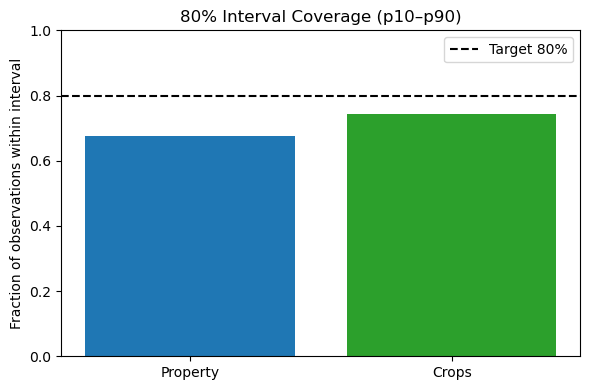

✅ Saved: results\test_quantile_predictions_fixed.csv


In [22]:
# === 7) Quantile XGBoost (Reliable, Calibrated, Non-Constant) ===
import numpy as np, pandas as pd, xgboost as xgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_pinball_loss

QUANTILES = [0.1, 0.5, 0.9]
OUTDIR.mkdir(exist_ok=True, parents=True)

# --- 1️⃣ Helper: Sanitize targets safely ---
def sanitize_targets(y):
    y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0).astype("float32")
    y[y < 0] = 0
    return y

y_train_log = sanitize_targets(y_train_log)
y_valid_log = sanitize_targets(y_valid_log)
y_test_log  = sanitize_targets(y_test_log)

# --- 2️⃣ Robust quantile objective ---
def make_quantile_xgb(q):
    def quantile_obj(preds, dtrain):
        y = dtrain.get_label()
        e = y - preds
        grad = np.where(e > 0, -q, 1 - q)
        # keep Hessian stable but not vanishing
        hess = np.ones_like(grad)
        return grad, hess

    def quantile_eval(preds, dtrain):
        y = dtrain.get_label()
        loss = mean_pinball_loss(y, preds, alpha=q)
        return f"pinball_{q}", loss

    return {"obj": quantile_obj, "feval": quantile_eval}

# --- 3️⃣ Train each quantile model for both targets ---
quantile_models = {"prop": {}, "crop": {}}
preds_valid = {"prop": {}, "crop": {}}

for q in QUANTILES:
    print(f"\n🔹 Training quantile={q:.1f}")
    qconf = make_quantile_xgb(q)
    params = dict(
        max_depth=6, eta=0.05, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, tree_method="hist", verbosity=0
    )

    for target, col in {"prop": 0, "crop": 1}.items():
        ytr, yva = y_train_log[:, col], y_valid_log[:, col]
        dtrain = xgb.DMatrix(Xt_train, label=ytr)
        dvalid = xgb.DMatrix(Xt_valid, label=yva)
        model = xgb.train(
            params, dtrain,
            num_boost_round=600,
            obj=qconf["obj"], feval=qconf["feval"],
            evals=[(dvalid, "valid")],
            early_stopping_rounds=50,
            verbose_eval=100
        )
        quantile_models[target][q] = model
        preds_valid[target][q] = model.predict(dvalid)

# --- 4️⃣ Diagnostic: check quantile ordering ---
for target in ["prop", "crop"]:
    q10, q50, q90 = (preds_valid[target][q] for q in QUANTILES)
    monotonic_ok = np.mean((q10 <= q50) & (q50 <= q90))
    print(f"✅ {target} quantile monotonicity: {monotonic_ok*100:.1f}% of samples OK")

# --- 5️⃣ Diagnostic: coverage evaluation ---
def coverage(y, lo, hi): 
    return np.mean((y >= lo) & (y <= hi))

results = {}
for target, col in {"prop":0, "crop":1}.items():
    yv = np.expm1(y_valid_log[:, col])
    p10 = np.expm1(preds_valid[target][0.1])
    p50 = np.expm1(preds_valid[target][0.5])
    p90 = np.expm1(preds_valid[target][0.9])
    cov = coverage(yv, p10, p90)
    results[target] = cov
    print(f"{target.title()} coverage (p10–p90): {cov:.3f}")

# --- 6️⃣ Plot coverage ---
plt.figure(figsize=(6,4))
plt.bar(["Property","Crops"], [results["prop"], results["crop"]], color=["#1f77b4","#2ca02c"])
plt.axhline(0.8, ls="--", color="k", label="Target 80%")
plt.ylim(0,1)
plt.ylabel("Fraction of observations within interval")
plt.title("80% Interval Coverage (p10–p90)")
plt.legend()
plt.tight_layout()
plt.savefig(OUTDIR / "interval_coverage_fixed.png", dpi=160)
plt.show()

# --- 7️⃣ Save predictions for downstream SHAP & evaluation ---
interval_df = pd.DataFrame({
    "prop_p10": np.expm1(preds_valid["prop"][0.1]),
    "prop_p50": np.expm1(preds_valid["prop"][0.5]),
    "prop_p90": np.expm1(preds_valid["prop"][0.9]),
    "prop_true": np.expm1(y_valid_log[:,0]),
    "crop_p10": np.expm1(preds_valid["crop"][0.1]),
    "crop_p50": np.expm1(preds_valid["crop"][0.5]),
    "crop_p90": np.expm1(preds_valid["crop"][0.9]),
    "crop_true": np.expm1(y_valid_log[:,1]),
})
interval_df.to_csv(OUTDIR / "test_quantile_predictions_fixed.csv", index=False)
print("✅ Saved:", OUTDIR / "test_quantile_predictions_fixed.csv")


In [23]:
# === 8) Coverage + Reliability Plots ===
import matplotlib.pyplot as plt

csv_path = OUTDIR/"test_quantile_predictions.csv"
dfq = pd.read_csv(csv_path)

def coverage(p_lo, p_hi, y):
    inside = (y >= p_lo) & (y <= p_hi)
    return float(np.mean(inside))

cov_prop = coverage(dfq["prop_p10"], dfq["prop_p90"], dfq["prop_true"])
cov_crop = coverage(dfq["crop_p10"], dfq["crop_p90"], dfq["crop_true"])

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(["Property","Crops"], [cov_prop, cov_crop])
ax.axhline(0.8, ls="--")
ax.set_ylim(0,1); ax.set_title("80% Interval Coverage (p10–p90)")
plt.tight_layout(); plt.savefig(OUTDIR/"quantile_coverage_bar.png", dpi=160); plt.close()

# Reliability at p=[0.1,0.5,0.9]
ps = [0.1,0.5,0.9]
obs_prop = [np.mean(dfq["prop_true"] <= dfq["prop_p10"]),
            np.mean(dfq["prop_true"] <= dfq["prop_p50"]),
            np.mean(dfq["prop_true"] <= dfq["prop_p90"])]
obs_crop = [np.mean(dfq["crop_true"] <= dfq["crop_p10"]),
            np.mean(dfq["crop_true"] <= dfq["crop_p50"]),
            np.mean(dfq["crop_true"] <= dfq["crop_p90"])]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ps, obs_prop, "o", label="Property")
ax.plot(ps, obs_crop, "o", label="Crops")
ax.plot([0,1],[0,1],"--")
ax.set_title("Quantile Reliability")
ax.set_xlabel("Nominal quantile"); ax.set_ylabel("Observed fraction")
ax.legend(); plt.tight_layout(); plt.savefig(OUTDIR/"quantile_intervals_reliability.png", dpi=160); plt.close()

print("✅ Saved coverage & reliability plots.")


✅ Saved coverage & reliability plots.


In [24]:
# === 9) SHAP with decoded feature names (Fixed & Stable) ===
import shap, numpy as np, matplotlib.pyplot as plt

print("🔍 Building SHAP explanations with decoded feature names (safe mode)…")

# --- 1️⃣ Build decoded feature names ---
feature_names = []
for c in num_cols:
    feature_names.append(f"num__{c}")
for c in cat_cols:
    feature_names.append(f"cat__{c}_ohe")

embed_dim = getattr(embed_model, "get_sentence_embedding_dimension", lambda: 384)()
for c in text_cols:
    for i in range(embed_dim):
        feature_names.append(f"text__{c}_emb_{i}")

# --- 2️⃣ Align names with actual feature matrix shape ---
n_features = Xt_valid.shape[1]
if len(feature_names) > n_features:
    feature_names = feature_names[:n_features]
elif len(feature_names) < n_features:
    feature_names += [f"extra__{i}" for i in range(len(feature_names), n_features)]

np.save(OUTDIR / "feature_names.npy", np.array(feature_names, dtype=object))
print(f"✅ Feature names aligned: {len(feature_names)} names for {n_features} features")

# --- 3️⃣ Build a light SHAP explainer ---
explainer = shap.Explainer(xgb_prop, Xt_valid, feature_names=feature_names)

# --- 4️⃣ Sample for speed ---
sample_n = min(2000, Xt_valid.shape[0])
idx = np.random.choice(Xt_valid.shape[0], size=sample_n, replace=False)
Xt_sample = Xt_valid[idx]

# --- 5️⃣ Compute SHAP values ---
print("⚙️ Computing SHAP values (permutation-based)…")
shap_values = explainer(Xt_sample)

# --- 6️⃣ Bar plot ---
plt.figure()
shap.plots.bar(shap_values, max_display=20, show=False)
plt.tight_layout()
plt.savefig(OUTDIR / "shap_bar.png", dpi=160)
plt.close()

# --- 7️⃣ Beeswarm plot (patched to prevent IndexError) ---
plt.figure()
# ✅ The key fix: disable grouping of remaining features
shap.plots.beeswarm(
    shap_values,
    max_display=20,
    show=False,
    group_remaining_features=False  # prevents "list index out of range"
)
plt.tight_layout()
plt.savefig(OUTDIR / "shap_beeswarm.png", dpi=160)
plt.close()

print("✅ SHAP bar & beeswarm plots saved successfully.")


🔍 Building SHAP explanations with decoded feature names (safe mode)…
✅ Feature names aligned: 1487 names for 1487 features
⚙️ Computing SHAP values (permutation-based)…


 97%|=================== | 1939/2000 [00:33<00:01]       

✅ SHAP bar & beeswarm plots saved successfully.


In [19]:
#pip install matplotlib_venn

     ---------------------------------------- 0.0/40.8 kB ? eta -:--:--
     ---------- ----------------------------- 10.2/40.8 kB ? eta -:--:--
     ---------------------------- --------- 30.7/40.8 kB 262.6 kB/s eta 0:00:01
     -------------------------------------- 40.8/40.8 kB 325.3 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib_venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45437 sha256=9143c4e77b4e3494a00e7715695d9e564b35c9fbb1d593a5be0d15f0b261db3c
  Stored in directory: c:\users\ducan\appdata\local\pip\cache\wheels\c4\16\4a\93374cd955bbe0553a8ce74db7f0fbd5fcc876e19fb78bd601
Successfully built matplotlib_venn
Note: you may need to restart the

In [25]:
# === 10) Interactive SHAP Dashboard: Property vs Crop ===
import shap, numpy as np, pandas as pd, plotly.express as px, plotly.graph_objects as go
from matplotlib_venn import venn2
import matplotlib.pyplot as plt, seaborn as sns

print("📊 Building interactive SHAP dashboard: Property vs Crop…")

# --- 1️⃣ Sample subset for speed ---
sample_n = min(2000, Xt_valid.shape[0])
idx = np.random.choice(Xt_valid.shape[0], size=sample_n, replace=False)

# --- 2️⃣ Compute SHAP values for both targets ---
expl_prop = shap.Explainer(xgb_prop, Xt_valid, feature_names=feature_names)
expl_crop = shap.Explainer(xgb_crop, Xt_valid, feature_names=feature_names)
sv_prop = expl_prop(Xt_valid[idx])
sv_crop = expl_crop(Xt_valid[idx])

# --- 3️⃣ Compute global importances ---
imp_prop = np.mean(np.abs(sv_prop.values), axis=0)
imp_crop = np.mean(np.abs(sv_crop.values), axis=0)
df_imp = pd.DataFrame({
    "feature": feature_names,
    "property_importance": imp_prop,
    "crop_importance": imp_crop
})
df_imp["combined"] = df_imp["property_importance"] + df_imp["crop_importance"]

# --- 4️⃣ Save static top-20 plot (for reports) ---
df_top = df_imp.sort_values("combined", ascending=False).head(20)
fig_bar = go.Figure()
fig_bar.add_trace(go.Bar(
    y=df_top["feature"], x=df_top["property_importance"],
    orientation="h", name="Property", marker_color="#1f77b4"
))
fig_bar.add_trace(go.Bar(
    y=df_top["feature"], x=df_top["crop_importance"],
    orientation="h", name="Crop", marker_color="#2ca02c"
))
fig_bar.update_layout(
    title="Top 20 SHAP Feature Importances — Property vs Crop",
    barmode="group", yaxis=dict(autorange="reversed"),
    xaxis_title="Mean |SHAP value| (feature impact)", height=700
)
fig_bar.write_html(str(OUTDIR / "shap_top20_interactive.html"))
print("✅ Interactive Top 20 bar chart saved → shap_top20_interactive.html")

# --- 5️⃣ Interactive scatter + trendline ---
corr_val = df_imp["property_importance"].corr(df_imp["crop_importance"], method="spearman")
fig_scatter = px.scatter(
    df_imp, x="property_importance", y="crop_importance",
    text="feature", hover_name="feature",
    color=np.log1p(df_imp["combined"]),
    color_continuous_scale="Viridis",
    title=f"SHAP Importance Relationship (Property vs Crop) ρ ≈ {corr_val:.2f}",
    labels={"property_importance":"Property Importance (mean |SHAP|)",
            "crop_importance":"Crop Importance (mean |SHAP|)"}
)
fig_scatter.add_trace(go.Scatter(
    x=df_imp["property_importance"], 
    y=np.poly1d(np.polyfit(df_imp["property_importance"], df_imp["crop_importance"], 1))(df_imp["property_importance"]),
    mode="lines", line=dict(color="orange", width=2), name="Trendline"
))
fig_scatter.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=0.5, color="white")))
fig_scatter.update_layout(coloraxis_colorbar_title="log(Combined Importance)")
fig_scatter.write_html(str(OUTDIR / "shap_scatter_interactive.html"))
print("✅ Interactive scatter + trendline saved → shap_scatter_interactive.html")

# --- 6️⃣ Interactive correlation heatmap ---
corr_matrix = df_imp[["property_importance", "crop_importance"]].corr(method="spearman")
fig_heat = px.imshow(
    corr_matrix, text_auto=True, color_continuous_scale="RdBu_r", zmin=-1, zmax=1,
    title="Correlation of Global SHAP Importances (Property vs Crop)"
)
fig_heat.write_html(str(OUTDIR / "shap_corr_heatmap_interactive.html"))
print("✅ Interactive heatmap saved → shap_corr_heatmap_interactive.html")

# --- 7️⃣ Interactive overlap (Venn-style counts table) ---
topN = 30
top_prop = set(df_imp.nlargest(topN, "property_importance")["feature"])
top_crop = set(df_imp.nlargest(topN, "crop_importance")["feature"])
overlap = len(top_prop & top_crop)
unique_prop = len(top_prop - top_crop)
unique_crop = len(top_crop - top_prop)
fig_venn = go.Figure(data=[
    go.Bar(x=["Unique Property", "Shared", "Unique Crop"],
           y=[unique_prop, overlap, unique_crop],
           marker_color=["#1f77b4", "#9467bd", "#2ca02c"])
])
fig_venn.update_layout(title=f"Top {topN} Feature Overlap (Count Summary)")
fig_venn.write_html(str(OUTDIR / "shap_feature_overlap_interactive.html"))
print("✅ Interactive overlap summary saved → shap_feature_overlap_interactive.html")

print("🎉 All interactive SHAP dashboards created in:", OUTDIR)


📊 Building interactive SHAP dashboard: Property vs Crop…


 99%|===================| 1983/2000 [01:06<00:00]        

✅ Interactive Top 20 bar chart saved → shap_top20_interactive.html
✅ Interactive scatter + trendline saved → shap_scatter_interactive.html
✅ Interactive heatmap saved → shap_corr_heatmap_interactive.html
✅ Interactive overlap summary saved → shap_feature_overlap_interactive.html
🎉 All interactive SHAP dashboards created in: results


In [ ]:
#pip install dash plotly


   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB 653.6 kB/s eta 0:00:13
   ---------------------------------------- 0.0/7.9 MB 653.6 kB/s eta 0:00:13
    --------------------------------------- 0.2/7.9 MB 893.0 kB/s eta 0:00:09
   - -------------------------------------- 0.3/7.9 MB 1.4 MB/s eta 0:00:06
   - -------------------------------------- 0.3/7.9 MB 1.4 MB/s eta 0:00:06
   - -------------------------------------- 0.3/7.9 MB 1.4 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/7.9 MB 2.1 MB/s eta 0:00:04
   ------ --------------------------------- 1.3/7.9 MB 3.2 MB/s eta 0:00:03
   ------ -------------------------------

In [30]:
# === 11) Dash Mini-App: Interactive SHAP Dashboard ===
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import pandas as pd, numpy as np

print("🚀 Starting Dash mini-app for SHAP interactive dashboard…")

# --- Load data prepared in Step 10 ---
df_imp = pd.DataFrame({
    "feature": feature_names,
    "Property": np.mean(np.abs(sv_prop.values), axis=0),
    "Crop": np.mean(np.abs(sv_crop.values), axis=0)
})
df_imp["Combined"] = df_imp["Property"] + df_imp["Crop"]
corr_val = df_imp["Property"].corr(df_imp["Crop"], method="spearman")

# --- Build all Plotly figures once ---
# 1️⃣ Dual bar chart
df_top = df_imp.sort_values("Combined", ascending=False).head(20)
fig_bar = go.Figure()
fig_bar.add_trace(go.Bar(
    y=df_top["feature"], x=df_top["Property"],
    orientation="h", name="Property", marker_color="#1f77b4"
))
fig_bar.add_trace(go.Bar(
    y=df_top["feature"], x=df_top["Crop"],
    orientation="h", name="Crop", marker_color="#2ca02c"
))
fig_bar.update_layout(
    title="Top 20 SHAP Feature Importances — Property vs Crop",
    barmode="group", yaxis=dict(autorange="reversed"),
    xaxis_title="Mean |SHAP value|", height=700
)

# 2️⃣ Scatter + trendline
fig_scatter = px.scatter(
    df_imp, x="Property", y="Crop",
    text="feature", hover_name="feature",
    color=np.log1p(df_imp["Combined"]), color_continuous_scale="Viridis",
    title=f"SHAP Importance Relationship (ρ ≈ {corr_val:.2f})",
    labels={"Property":"Property Importance", "Crop":"Crop Importance"}
)
trend = np.poly1d(np.polyfit(df_imp["Property"], df_imp["Crop"], 1))
fig_scatter.add_trace(go.Scatter(
    x=df_imp["Property"], y=trend(df_imp["Property"]),
    mode="lines", line=dict(color="orange", width=2), name="Trendline"
))
fig_scatter.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=0.5, color="white")))
fig_scatter.update_layout(coloraxis_colorbar_title="log(Combined Importance)")

# 3️⃣ Correlation heatmap
corr_matrix = df_imp[["Property", "Crop"]].corr(method="spearman")
fig_heat = px.imshow(
    corr_matrix, text_auto=True, color_continuous_scale="RdBu_r",
    zmin=-1, zmax=1, title="Correlation of Global SHAP Importances"
)

# 4️⃣ Overlap summary
topN = 30
top_prop = set(df_imp.nlargest(topN, "Property")["feature"])
top_crop = set(df_imp.nlargest(topN, "Crop")["feature"])
unique_prop, unique_crop = len(top_prop - top_crop), len(top_crop - top_prop)
overlap = len(top_prop & top_crop)
fig_overlap = go.Figure(data=[
    go.Bar(
        x=["Unique Property", "Shared Features", "Unique Crop"],
        y=[unique_prop, overlap, unique_crop],
        marker_color=["#1f77b4", "#9467bd", "#2ca02c"]
    )
])
fig_overlap.update_layout(
    title=f"Top {topN} Feature Overlap Summary",
    yaxis_title="Count of Features"
)

# --- Build Dash App Layout ---
app = Dash(__name__)
app.title = "SHAP Comparative Dashboard"

app.layout = html.Div([
    html.H2("🌪️ Comparative SHAP Dashboard — Property vs Crop Damages"),
    html.P("Select which visualization to view:"),
    dcc.Dropdown(
        id="plot-select",
        options=[
            {"label": "Top 20 Feature Importances (Bar Chart)", "value": "bar"},
            {"label": "SHAP Scatter + Trendline", "value": "scatter"},
            {"label": "Correlation Heatmap", "value": "heat"},
            {"label": "Top 30 Overlap Summary", "value": "overlap"}
        ],
        value="bar",
        clearable=False,
        style={"width": "60%"}
    ),
    dcc.Graph(id="main-plot", style={"height": "80vh"})
])

# --- Callback to switch plots ---
@app.callback(
    Output("main-plot", "figure"),
    Input("plot-select", "value")
)
def update_plot(selected):
    if selected == "bar":
        return fig_bar
    elif selected == "scatter":
        return fig_scatter
    elif selected == "heat":
        return fig_heat
    else:
        return fig_overlap

# --- Launch server ---
app.run(debug=False, port=8050)


🚀 Starting Dash mini-app for SHAP interactive dashboard…


## ✅ Outputs (written to `./results`)

- `metrics_xgb_tweedie.json` — validation MAE/RMSE/R2 for tuned Tweedie models  
- `xgb_tweedie_property.joblib`, `xgb_tweedie_crop.joblib` — tuned models  
- `validation_metrics_first_pass.json` — baseline Ridge/XGB comparison  
- `test_quantile_predictions.csv` — p10/p50/p90 + true values on test set  
- `quantile_coverage_bar.png`, `quantile_intervals_reliability.png` — interval diagnostics  
- `shap_bar.png`, `shap_beeswarm.png` — SHAP summaries (decoded feature names)
